In [1]:
%matplotlib notebook

import sys
sys.path.append("../src")

import glob
import copy
import aplpy
import numpy
import scipy
import colorcet
import matplotlib
from scipy import ndimage
from matplotlib import pyplot
# pyplot.switch_backend("Qt4Agg")
from astropy.io import ascii, fits
from mpl_toolkits.axes_grid1 import make_axes_locatable

import parse
import convert

from cluster import Cluster
from simulation import Simulation
from parse import psmac2_fitsfile
from rotate import apply_projection
from parse import toycluster_icfile
from main import new_argument_parser
# from plotsettings import PlotSettings
# style = PlotSettings()

def p2(a):
    return ((a) * (a))

pyplot.switch_backend("module://ipykernel.pylab.backend_inline")

/usr/local/AMUSE/prerequisites-10.0/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
# First we find observed CygA centroid, and 'boxsize'
lss_Lx = "/usr/local/mscproj/runs/ChandraObservation/lss/cygnus_lss_fill_flux_2Msec.fits"
lss_kT = "/usr/local/mscproj/runs/ChandraObservation/lss/working_spectra_kT_map_2Msec.fits"
mosaic_Lx = fits.open(lss_Lx)
mosaic_kT = fits.open(lss_kT)
contour_smooth = scipy.ndimage.filters.gaussian_filter(mosaic_Lx[0].data, 25)
kT_smooth = scipy.ndimage.filters.gaussian_filter(mosaic_kT[0].data, 9)

# Find the centroid of CygA to align simulation and observation later on
maxcounts_obs = mosaic_Lx[0].data.max()
maxcounts_obs_index = mosaic_Lx[0].data.argmax()  # of flattened array
ylen_obs_pix, xlen_obs_pix = mosaic_Lx[0].data.shape
xcenter_obs = maxcounts_obs_index % xlen_obs_pix
ycenter_obs = maxcounts_obs_index / xlen_obs_pix

# Find the dimensions of the Chandra image in pix, arcsec and kpc
xlen_obs_pix = mosaic_Lx[0].header["NAXIS1"]  # same as using mosaic_smooth.shape
ylen_obs_pix = mosaic_Lx[0].header["NAXIS2"]
pix2arcsec_obs = mosaic_Lx[0].header["CDELT2"]*3600  # Chandra size of pixel 0.492". Value in header is in degrees.
xlen_obs_arcsec = xlen_obs_pix * pix2arcsec_obs
ylen_obs_arcsec = ylen_obs_pix * pix2arcsec_obs
from cosmology import CosmologyCalculator
cc = CosmologyCalculator(0.0562)
arcsec2kpc = cc.kpc_DA
pix2kpc_obs = pix2arcsec_obs * arcsec2kpc
xlen_obs_kpc = xlen_obs_arcsec * arcsec2kpc
ylen_obs_kpc = ylen_obs_arcsec * arcsec2kpc
zlen_obs_kpc = ylen_obs_kpc

print "Chandra Observation [lss_fill_flux]"
print "  Shape ({0},   {1})   pixels".format(xlen_obs_pix, ylen_obs_pix)
print "  Shape ({0:.1f}, {1:.1f}) arcsec".format(xlen_obs_arcsec, ylen_obs_arcsec)
print "  Shape ({0:.1f}, {1:.1f}) kpc".format(xlen_obs_kpc, ylen_obs_kpc)
print "  CygA at ({0}, {1}) pixels. Value = {2:2.2g}".format(xcenter_obs, ycenter_obs, maxcounts_obs)


Chandra Observation [lss_fill_flux]
  Shape (2051,   2151)   pixels
  Shape (1009.1, 1058.3) arcsec
  Shape (1100.6, 1154.3) kpc
  CygA at (665, 576) pixels. Value = 7.4e-05


In [4]:
bestfit = "/Users/Timohalbesma/Desktop/snapshot_147_010"
header, gas, dm = toycluster_icfile(bestfit)

boxsize = header["boxSize"]
boxhalf = boxsize/2

# Use Cluster instance to hold data. Toycluster parms needed for find_dm_centroid
c = Cluster(header)
c.set_header_properties()
# c.parms = parse.read_toycluster_parameterfile(glob.glob(simdir+"../ICs/*.par")[0])
c.parms = parse.read_toycluster_parameterfile(
    "/Users/Timohalbesma/Desktop/ic_both_free_cut_25.par")

# !! Domain [-boxhalf, boxhalf] for rotation matrices !!
gas["x"] -= boxhalf
gas["y"] -= boxhalf
gas["z"] -= boxhalf
dm["x"]  -= boxhalf
dm["y"]  -= boxhalf
dm["z"]  -= boxhalf

# This seems best-fit rotation angles
EulAng = numpy.array([90, 51, 45]) 
gas, dm = apply_projection(EulAng, gas, dm)

# Now find centroids in rotated image to place cygA and fidicual
# cygA at same location in plot. !! Domain find_dm_centroid [0, boxSize] !!
gas["x"] += boxhalf
gas["y"] += boxhalf
gas["z"] += boxhalf
dm["x"]  += boxhalf
dm["y"]  += boxhalf
dm["z"]  += boxhalf

c.dm, c.gas = dm, gas
ImpactParam = c.parms["ImpactParam"]
c.parms["ImpactParam"] = 1337  # not 0.0
c.find_dm_centroid(single=False)
c.parms["ImpactParam"] = ImpactParam  # put back

xcenter_sim = c.centroid0[0]
ycenter_sim = c.centroid0[1]
zcenter_sim = c.centroid0[2]

print "Gadget3 Snapshot"
print "  CygA at ({0}, {1}, {2}).".format(xcenter_sim, ycenter_sim, zcenter_sim)

gas["x"] = gas["x"] - xcenter_sim + xcenter_obs*pix2kpc_obs
gas["y"] = gas["y"] - ycenter_sim + ycenter_obs*pix2kpc_obs
gas["z"] = gas["z"] - zcenter_sim + ycenter_obs*pix2kpc_obs
dm["x"] = dm["x"] - xcenter_sim + xcenter_obs*pix2kpc_obs
dm["y"] = dm["y"] - ycenter_sim + ycenter_obs*pix2kpc_obs
dm["z"] = dm["z"] - zcenter_sim + ycenter_obs*pix2kpc_obs

    Success: found 2 xpeaks, 2 ypeak, and 2 zpeak!
      halo0:  (x, y, z) = (5857.3000000000002, 5778.3000000000002, 5657.4000000000005)
      halo1:  (x, y, z) = (6325.6000000000004, 6365.2000000000007, 5657.4000000000005)
      distance          = 750.84 kpc

Gadget3 Snapshot
  CygA at (5857.3, 5778.3, 5657.4).


In [5]:
zoomx = float(ylen_obs_pix) / xlen_obs_kpc
zoomy = float(xlen_obs_pix) / ylen_obs_kpc
shape_matched = scipy.ndimage.zoom(contour_smooth,  [1/zoomx, 1/zoomy], order=3)

/usr/local/AMUSE/prerequisites-10.0/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [6]:
ishock, = numpy.where(
      ((gas["x"] > 0.) & (gas["x"] < xlen_obs_kpc))
    & ((gas["y"] > 0.) & (gas["y"] < ylen_obs_kpc))
    & ((gas["z"] > 0.) & (gas["z"] < ylen_obs_kpc))
    & (gas["mach"] > 1.1)
)

pyplot.figure()
hist, edges = numpy.histogram(gas["mach"][ishock], bins=16, normed=False)
edges = (edges[:-1] + edges[1:])/2
pyplot.plot(edges, hist, drawstyle="steps-mid")
pyplot.xlim(1.1, 2.5)
pyplot.yscale("log")
pyplot.ylabel("No. of SPH particles")
pyplot.xlabel("Mach Number")
pyplot.savefig("../out/mach_distribution_bestfit.pdf")

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# pyplot.switch_backend("Cairo")
fig, ax1 = pyplot.subplots(1, 1, figsize=(8, 8))

# Simulation
norm = matplotlib.colors.LogNorm()
h, xe, ye = numpy.histogram2d(dm["x"], dm["y"], bins=2048)
im = ax1.pcolormesh(xe, ye, numpy.ma.masked_less_equal(h.T, 100),
    cmap=colorcet.cm["linear_blue_95_50_c20"], 
    norm=norm, vmin=150, vmax=3000)

# And now we add the shock
pyplot.plot(gas["x"][ishock], gas["y"][ishock], "rX", ms=5)

# Observation: contours
delta = 1
x = numpy.arange(0, xlen_obs_kpc, delta)
y = numpy.arange(0, int(ylen_obs_kpc), delta)
X, Y = numpy.meshgrid(y, x)
CS = pyplot.contour(X, Y, numpy.log10(shape_matched.clip(10**-8.8)), 7,
    colors="black", linestyles="solid", origin="lower")

ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_xlim(0, xlen_obs_kpc)
ax1.set_ylim(0, ylen_obs_kpc)
ax1.set_xticks([], [])
ax1.set_yticks([], [])
ax1.set_aspect(1)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
pyplot.colorbar(im, cax=cax, label="Dark Matter [arbitrary units]")
pyplot.tight_layout()
pyplot.savefig("../out/WhereSitsTheShock.png", dpi=1200)

# pyplot.switch_backend("module://ipykernel.pylab.backend_inline")

In [8]:
fig, (ax1) = pyplot.subplots(1, 1, figsize=(8, 8))

im = ax1.imshow(numpy.log10(shape_matched),
        cmap=colorcet.cm["linear_bmw_5_95_c86"], origin="lower",
vmin=numpy.log10(7.0e-10), vmax=numpy.log10(1.0e-7))
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
pyplot.colorbar(im, cax=cax, label="kT [KeV]")

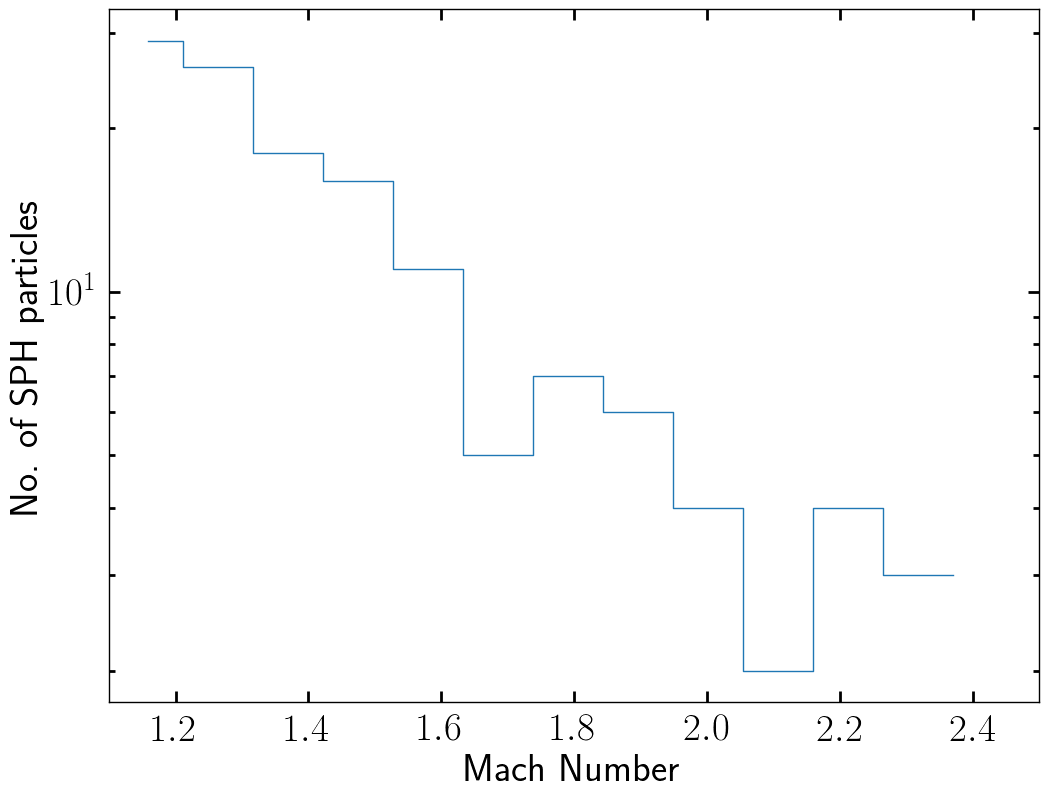

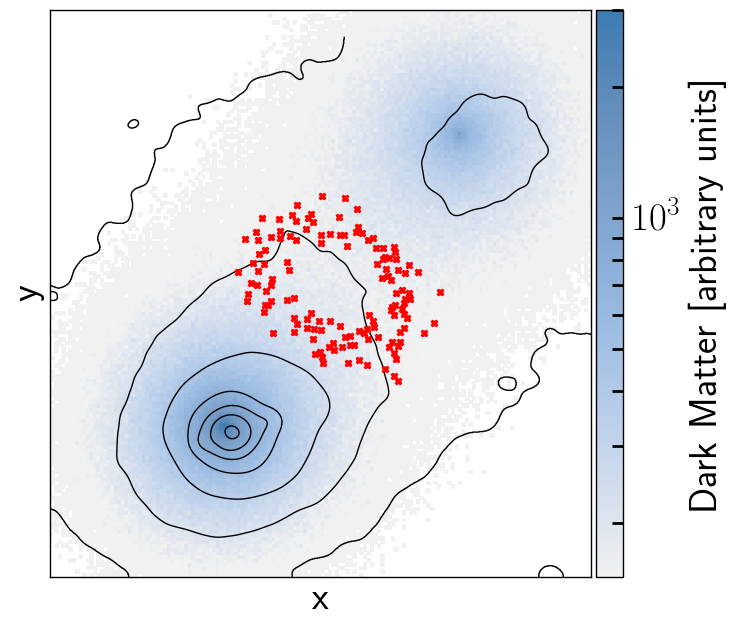

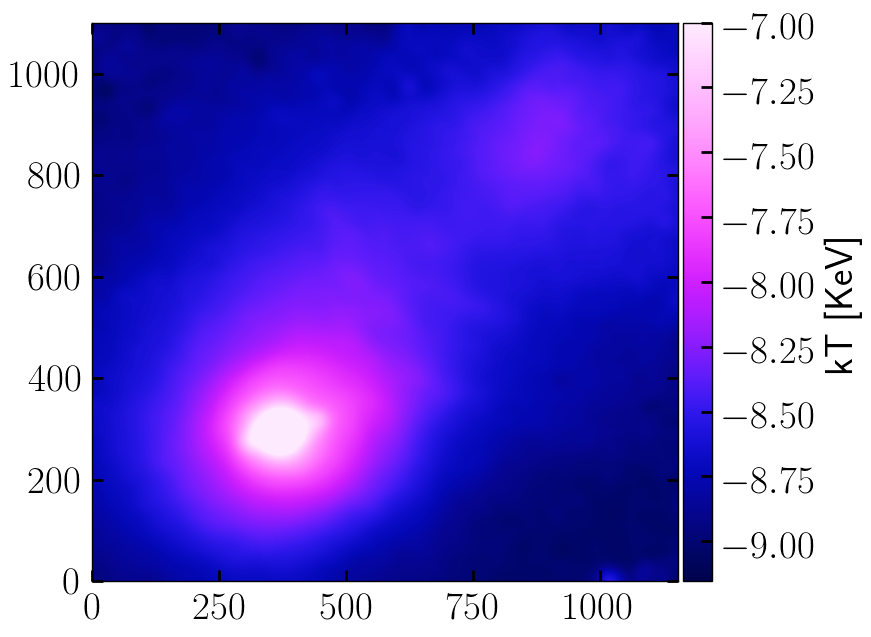

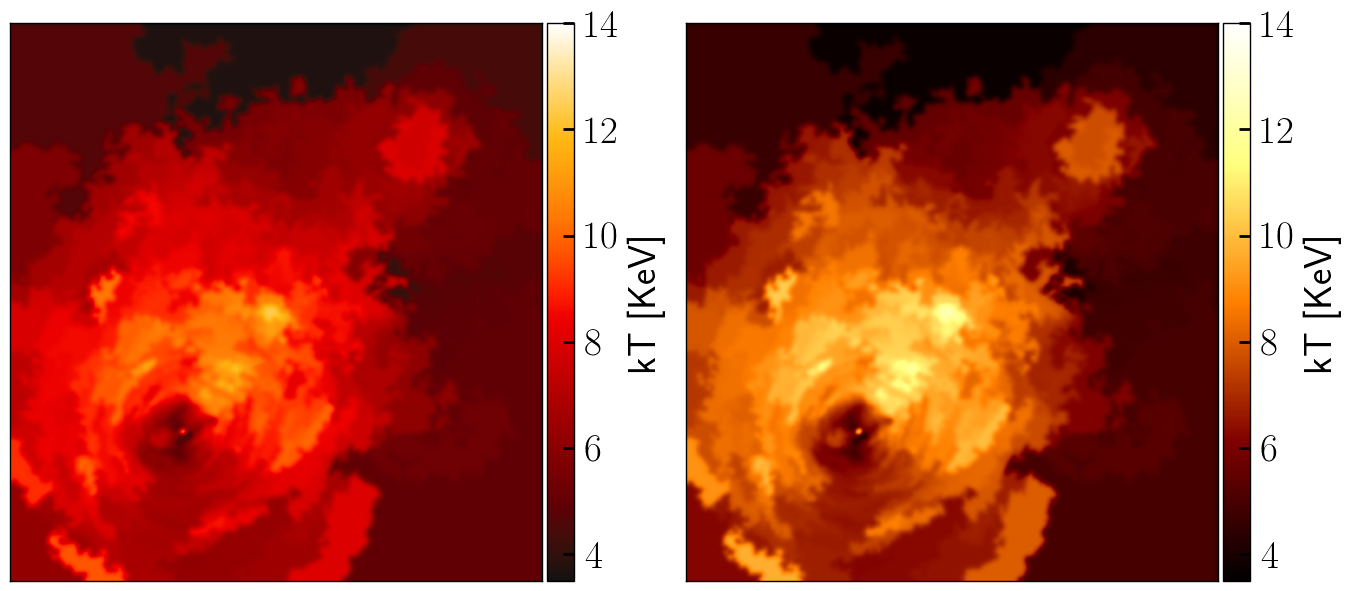

In [9]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(16, 8))

im = ax1.imshow(kT_smooth, origin="lower", vmin=3.5, vmax=14, 
    cmap=colorcet.cm["linear_kryw_5_100_c67"])
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
pyplot.colorbar(im, cax=cax, label="kT [KeV]")

im = ax2.imshow(kT_smooth, origin="lower", vmin=3.5, vmax=14,
    cmap="afmhot")
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
pyplot.colorbar(im, cax=cax, label="kT [KeV]")

for ax in [ax1, ax2]:
    ax.set_xticks([], []); ax.set_yticks([], [])

pyplot.show()

In [10]:
ids = gas[ishock]["id"]

In [11]:
bestfit = "/Users/Timohalbesma/Desktop/snapshot_147_010"
header, gas, dm = toycluster_icfile(bestfit)

boxsize = header["boxSize"]
boxhalf = boxsize/2

In [12]:
print(len(ishock))

# Grab indices from ishock, then plot those for unrotated snapshot
ishock_all, = numpy.where(numpy.in1d(gas["id"], ids))
print(len(ishock_all))

133
133


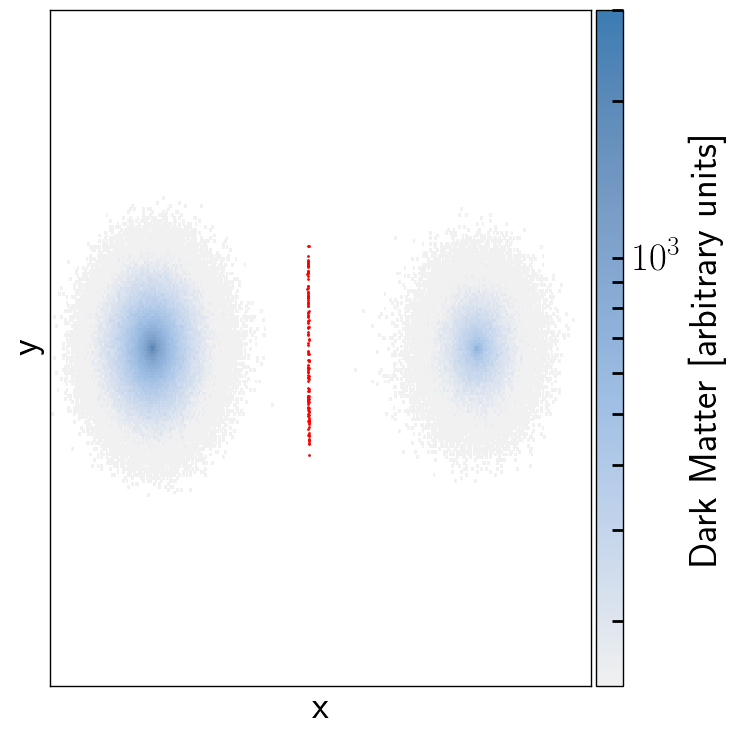

In [13]:
# pyplot.switch_backend("Cairo")
fig, ax1 = pyplot.subplots(1, 1, figsize=(8, 8))

# Simulation
norm = matplotlib.colors.LogNorm()
h, xe, ye = numpy.histogram2d(dm["x"], dm["y"], bins=2048)
im = ax1.pcolormesh(xe, ye, numpy.ma.masked_less_equal(h.T, 100),
    cmap=colorcet.cm["linear_blue_95_50_c20"], 
    norm=norm, vmin=150, vmax=3000)

# And now we add the shock
pyplot.plot(gas["x"][ishock_all], gas["y"][ishock_all], "ro", ms=1)

ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_xticks([], [])
ax1.set_yticks([], [])
pyplot.xlim(boxhalf-1100, boxhalf+700)
pyplot.ylim(boxhalf-700, boxhalf+700)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
pyplot.colorbar(im, cax=cax, label="Dark Matter [arbitrary units]")
pyplot.tight_layout()
pyplot.savefig("../out/WhereSitsTheShock_unrotated_xy.png", dpi=1200)
pyplot.show()

# pyplot.switch_backend("module://ipykernel.pylab.backend_inline")

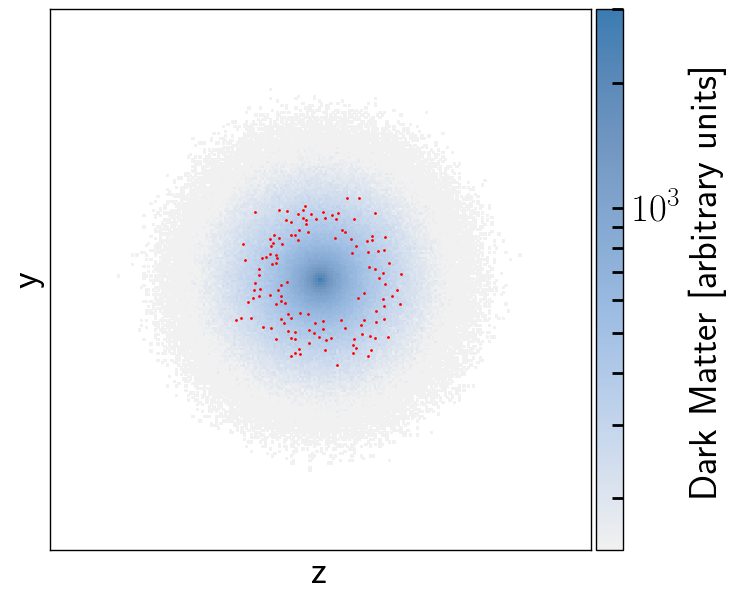

In [14]:
# pyplot.switch_backend("Cairo")
fig, ax1 = pyplot.subplots(1, 1, figsize=(8, 8))

# Simulation
norm = matplotlib.colors.LogNorm()
h, xe, ye = numpy.histogram2d(dm["z"], dm["y"], bins=2048)
im = ax1.pcolormesh(xe, ye, numpy.ma.masked_less_equal(h.T, 100),
    cmap=colorcet.cm["linear_blue_95_50_c20"], 
    norm=norm, vmin=150, vmax=3000)

# And now we add the shock
pyplot.plot(gas["z"][ishock_all], gas["y"][ishock_all], "ro", ms=1)

ax1.set_xlabel("z")
ax1.set_ylabel("y")
ax1.set_xticks([], [])
ax1.set_yticks([], [])
pyplot.xlim(boxhalf-700, boxhalf+700)
pyplot.ylim(boxhalf-700, boxhalf+700)
ax1.set_aspect(1)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
pyplot.colorbar(im, cax=cax, label="Dark Matter [arbitrary units]")
pyplot.tight_layout()
pyplot.savefig("../out/WhereSitsTheShock_unrotated_zy.png", dpi=1200)
pyplot.show()
# pyplot.switch_backend("module://ipykernel.pylab.backend_inline")

In [15]:
ishock_all, = numpy.where(
      (gas["mach"] > 1.1)
    # & (gas["x"] > boxhalf-700) & (gas["x"] < boxhalf+700)
    # & (gas["y"] > boxhalf-700) & (gas["y"] < boxhalf+700)
    # & (gas["z"] > boxhalf-700) & (gas["z"] < boxhalf+700)
)


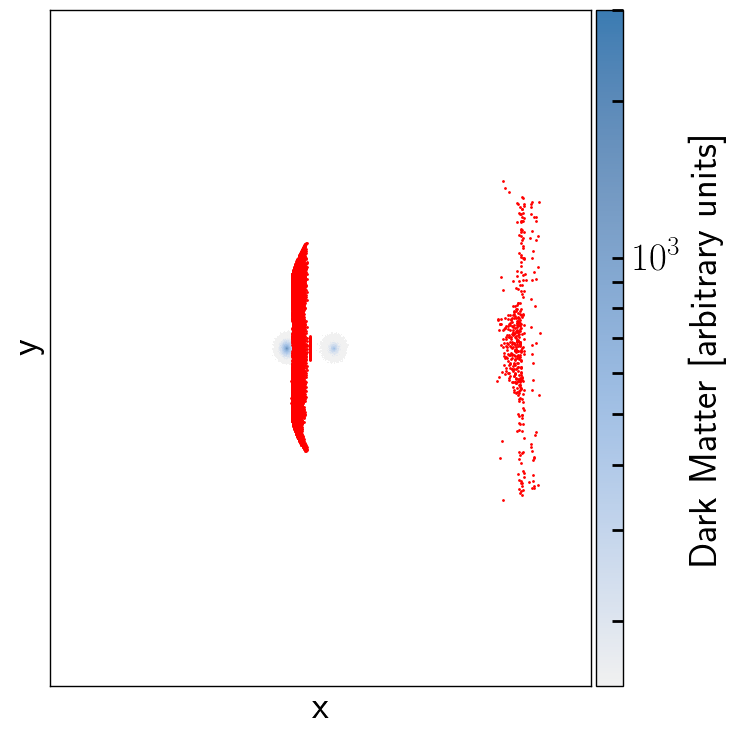

In [16]:
# pyplot.switch_backend("Cairo")
fig, ax1 = pyplot.subplots(1, 1, figsize=(8, 8))

# Simulation
norm = matplotlib.colors.LogNorm()
h, xe, ye = numpy.histogram2d(dm["x"], dm["y"], bins=2048)
im = ax1.pcolormesh(xe, ye, numpy.ma.masked_less_equal(h.T, 100),
    cmap=colorcet.cm["linear_blue_95_50_c20"], 
    norm=norm, vmin=150, vmax=3000)

# And now we add the shock
pyplot.plot(gas["x"][ishock_all], gas["y"][ishock_all], "ro", ms=1)

ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_xticks([], [])
ax1.set_yticks([], [])
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
pyplot.colorbar(im, cax=cax, label="Dark Matter [arbitrary units]")
pyplot.tight_layout()
pyplot.savefig("../out/WhereSitsTheShock_unrotated_xy_all.png", dpi=1200)
pyplot.show()

# pyplot.switch_backend("module://ipykernel.pylab.backend_inline")

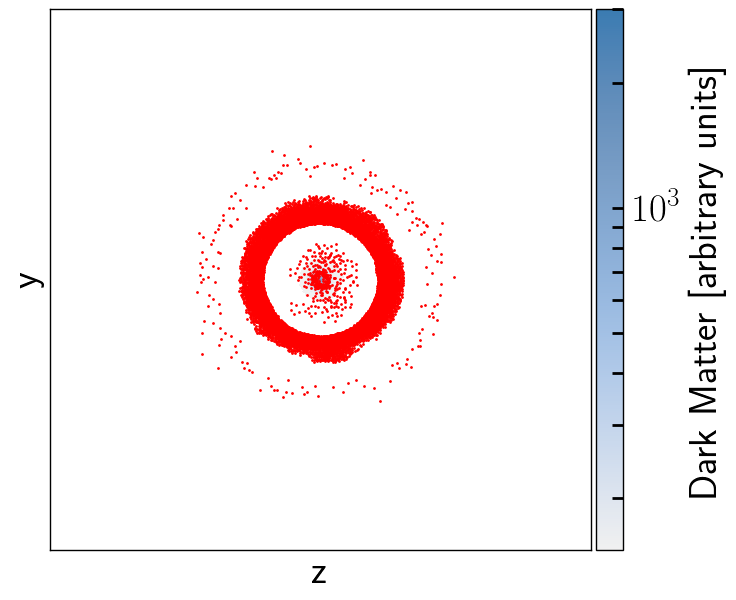

In [17]:
# pyplot.switch_backend("Cairo")
fig, ax1 = pyplot.subplots(1, 1, figsize=(8, 8))

# Simulation
norm = matplotlib.colors.LogNorm()
h, xe, ye = numpy.histogram2d(dm["z"], dm["y"], bins=2048)
im = ax1.pcolormesh(xe, ye, numpy.ma.masked_less_equal(h.T, 100),
    cmap=colorcet.cm["linear_blue_95_50_c20"], 
    norm=norm, vmin=150, vmax=3000)

# And now we add the shock
pyplot.plot(gas["z"][ishock_all], gas["y"][ishock_all], "ro", ms=1)

ax1.set_xlabel("z")
ax1.set_ylabel("y")
ax1.set_xticks([], [])
ax1.set_yticks([], [])
ax1.set_aspect(1)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
pyplot.colorbar(im, cax=cax, label="Dark Matter [arbitrary units]")
pyplot.tight_layout()
pyplot.savefig("../out/WhereSitsTheShock_unrotated_zy_all.png", dpi=1200)
pyplot.show()
# pyplot.switch_backend("module://ipykernel.pylab.backend_inline")

In [ ]:
mosaic_Lx[0].data.shape

In [ ]:
Lx_nxn = mosaic_Lx[0].data[:2051,:]
kT_nxn = mosaic_kT[0].data[:2051,:]

In [ ]:
Lx_nxn.shape

In [ ]:
delta = 1
x = numpy.arange(0, Lx_nxn.shape[0], delta)
y = numpy.arange(0, Lx_nxn.shape[0], delta)
Z = numpy.meshgrid(x, y, c=kT_nxn)

In [ ]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(16, 8))
ax1.imshow(scipy.ndimage.gaussian_filter(
    numpy.log10(Lx_nxn.clip(10**-8.8)), 25), origin="lower")

ax2.imshow(scipy.ndimage.gaussian_filter(kT_nxn, 25), origin="lower")

In [ ]:
Lx_obs = dict()
Lx_obs["x"] = Lx_nxn[0]
Lx_obs["y"] = Lx_nxn[:,0]
Lx_obs["z"] = 0

kT_obs = dict()
kT_obs["x"] = kT_nxn[0]
kT_obs["y"] = kT_nxn[:,0]
kT_obs["z"] = 0

In [ ]:
EulAng = numpy.array([-90, -51, -45]) 
Lx_obs_rot, kT_obs_rot = apply_projection(EulAng, Lx_obs, kT_obs)